# Insurance Risk Analytics - Task 3

In [1]:
# Load and Prepare the data 
# 1. Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

# 2. Load the data
df = pd.read_csv('E:/Tenx/Week 3/data/cleaned_insurance_data.csv')

# 3. Preview
print(df.shape)
df.head()


C:\Users\betsi\AppData\Local\Temp\ipykernel_11020\4032127681.py:11: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('E:/Tenx/Week 3/data/cleaned_insurance_data.csv')


(1000096, 47)


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


In [2]:
# **** Data Cleaning & Metric Engineering

# Claim Frequency (binary)
df['ClaimFrequency'] = (df['TotalClaims'] > 0).astype(int)

# Claim Severity (only if a claim exists)
df['ClaimSeverity'] = df['TotalClaims']
df.loc[df['ClaimFrequency'] == 0, 'ClaimSeverity'] = np.nan

# Margin (Profit)
df['Margin'] = df['TotalPremium'] - df['TotalClaims']

df[['ClaimFrequency', 'ClaimSeverity', 'Margin']].describe()


,ClaimFrequency,ClaimSeverity,Margin
count,1.000096e+06,2788.000000,1.000096e+06
mean,2.787732e-03,23273.387063,-2.955787e+00
std,5.272536e-02,38719.512597,2.367139e+03
min,0.000000e+00,139.043860,-3.928486e+05
25%,0.000000e+00,1680.728070,0.000000e+00
50%,0.000000e+00,6140.350877,2.157654e+00
75%,0.000000e+00,30480.991228,2.192982e+01
max,1.000000e+00,393092.105263,6.528260e+04


### Null Hypotheses to Test

H₀₁: There are no risk differences across provinces.  
H₀₂: There are no risk differences between zip codes.  
H₀₃: There are no significant margin differences between zip codes.  
H₀₄: There are no significant risk differences between women and men.


In [3]:
# 1. Test: Risk Differences Across Provinces
# Filter groups
grouped = df.groupby('Province')

# Compare mean ClaimFrequency between provinces using ANOVA
anova_result = stats.f_oneway(*[group['ClaimFrequency'].dropna() for name, group in grouped])
print(f"ANOVA p-value for Claim Frequency across Provinces: {anova_result.pvalue:.4f}")


ANOVA p-value for Claim Frequency across Provinces: 0.0000


In [6]:
# 2. Test: Risk Differences Between Zip Codes

top_zipcodes = df['PostalCode'].value_counts().nlargest(10).index
zip_subset = df[df['PostalCode'].isin(top_zipcodes)]

zip_grouped = zip_subset.groupby('PostalCode')
anova_result = stats.f_oneway(*[group['ClaimFrequency'].dropna() for name, group in zip_grouped])
print(f"ANOVA p-value for Claim Frequency across Top 10 PostalCodes: {anova_result.pvalue:.4f}")


ANOVA p-value for Claim Frequency across Top 10 PostalCodes: 0.0000


In [7]:
# 3. Test: Margin Difference Between Zip Codes

anova_margin = stats.f_oneway(*[group['Margin'].dropna() for name, group in zip_grouped])
print(f"ANOVA p-value for Margin across Top 10 ZipCodes: {anova_margin.pvalue:.4f}")


ANOVA p-value for Margin across Top 10 ZipCodes: 0.3964


In [8]:
# 4 Test: Risk Difference Between Women and Men

male = df[df['Gender'] == 'Male']['ClaimFrequency']
female = df[df['Gender'] == 'Female']['ClaimFrequency']

t_result = stats.ttest_ind(male.dropna(), female.dropna(), equal_var=False)
print(f"T-test p-value for Gender Claim Frequency difference: {t_result.pvalue:.4f}")


T-test p-value for Gender Claim Frequency difference: 0.8372


### Visualize Key Insights 

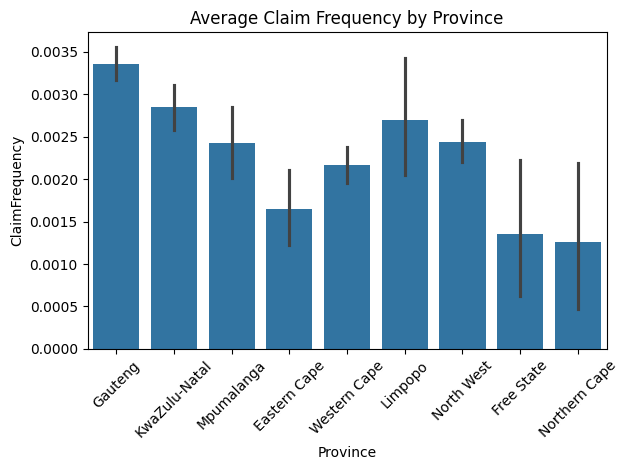

In [9]:
sns.barplot(data=df, x='Province', y='ClaimFrequency')
plt.xticks(rotation=45)
plt.title('Average Claim Frequency by Province')
plt.tight_layout()
plt.show()


### H₀₁: There are no risk differences across provinces.

- **Test Used**: ANOVA
- **p-value** = 0.0000

🔍 **Interpretation**: The p-value is far below the standard significance level of 0.05.

📉 **Conclusion**: We **reject the null hypothesis**. This means there is strong statistical evidence that **claim frequency significantly varies across provinces**.

💡 **Business Implication**: Premium pricing and risk models should account for **provincial-level risk variations**. Consider geographic-based segmentation strategies for risk adjustment.


### H₀₂: There are no risk differences between zip codes.

- **Test Used**: ANOVA (Top 10 Zip Codes)
- **p-value** = 0.0000

🔍 **Interpretation**: The p-value is also significantly below 0.05.

📉 **Conclusion**: We **reject the null hypothesis**. There is strong evidence that **claim frequency varies significantly between zip codes**.

💡 **Business Implication**: Zip code can be a **granular predictor of claim risk**. Consider incorporating it into underwriting or fraud detection models.


### H₀₃: There are no significant margin differences between zip codes.

- **Test Used**: ANOVA (Top 10 Zip Codes)
- **p-value** = 0.3964

🔍 **Interpretation**: The p-value is **greater than 0.05**, indicating insufficient evidence to reject the null.

📈 **Conclusion**: We **fail to reject the null hypothesis**. There is **no statistically significant difference** in average margins between zip codes.

💡 **Business Implication**: While claim risk varies, **profitability (margin) appears more uniform** across zip codes. Focus on **other factors** like customer demographics or product mix to explain margin variation.


### H₀₄: There are no significant risk differences between women and men.

- **Test Used**: T-test
- **p-value** = 0.8372

🔍 **Interpretation**: The p-value is far **above 0.05**, indicating no significant difference.

📈 **Conclusion**: We **fail to reject the null hypothesis**. There is **no statistical evidence** that claim frequency differs between genders.

💡 **Business Implication**: Gender may not be a strong predictor of claim risk in this dataset. Consider focusing on **geographic or policy-related variables** instead.
